# Homework 2 (66 pts)

## Overview
This homework will focus on checking the global and local spatial autocorrelation and point pattern analysis based on the Airbnb listing in New York City and the underlying socioeconomics. Through this practice, you will review the process of retrieving data from API, building spatial weights from georeferenced data, checking global and local spatial autocorrelation, and conducting point pattern analysis. 

## Grading
Each exercise will be graded based on the following rubrics:
- 2 points. Completed the task, presented the expected results, and codes were well documented and explained.
- 1 point. Completed the task with some disparity from the expected results.
- 0 point. Did not complete the excercise.

## Late submission policy
For late submission, every extra day after the due date will lead to 20% off of your points. Less than a day will be counted as one day. All submissions after the TA team posts the answers will not be accepted.

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import shape
import cenpy
from matplotlib import pyplot as plt
import matplotlib.colors as colors


from pysal.lib import weights
import seaborn as sns
from pysal.explore import esda
import contextily as ctx
from pointpats import centrography, QStatistic
from matplotlib.patches import Ellipse

/var/folders/c5/dps3lj6n2sz8zkk_381lj9b1hnpv4f/T/ipykernel_7028/2109066433.py:3: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd
/opt/anaconda3/envs/gds_py/lib/python3.9/site-packages/spaghetti/network.py:39: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries.

## 1. Read and Clean Data
### 1.1 Read and Clean Census Tract Data (4 pts)
Homework 1 presented detailed steps of downloading and cleaning census tract data while here you can try Socrata to retrieve the same dataset. Use the following link: https://data.cityofnewyork.us/City-Government/2020-Census-Tracts-Tabular/63ge-mke6 and find the API Endpoint. 
- Specify the BoroName as Manhattan in the url. (2 pts)
- Transform the downloaded dataframe into a geodataframe and set the crs as 4326. (2 pts)

Present the geodataframe (name it as **ct**).

In [2]:
#Read in data from API, filter by boroname
ct = pd.read_json("https://data.cityofnewyork.us/resource/63ge-mke6.json?boroname=Manhattan")
#Transform to geodataframe
ct['the_geom'] = ct['the_geom'].apply(shape)
ct = gpd.GeoDataFrame(ct,geometry='the_geom', crs = 4326)
ct

,the_geom,ctlabel,borocode,boroname,ct2020,boroct2020,ntaname,nta2020,cdta2020,cdtaname,geoid,shape_leng,shape_area
0,"MULTIPOLYGON (((-74.04388 40.69019, -74.04351 ...",1.00,1,Manhattan,100,1000100,The Battery-Governors Island-Ellis Island-Libe...,MN0191,MN01,MN01 Financial District-Tribeca (CD 1 Equivalent),36061000100,11023.048501,1.844421e+06
1,"MULTIPOLYGON (((-73.98450 40.70951, -73.98655 ...",2.01,1,Manhattan,201,1000201,Chinatown-Two Bridges,MN0301,MN03,MN03 Lower East Side-Chinatown (CD 3 Equivalent),36061000201,4754.495247,9.723121e+05
2,"MULTIPOLYGON (((-73.99022 40.71440, -73.98934 ...",6.00,1,Manhattan,600,1000600,Chinatown-Two Bridges,MN0301,MN03,MN03 Lower East Side-Chinatown (CD 3 Equivalent),36061000600,6976.286456,2.582705e+06
3,"MULTIPOLYGON (((-73.98837 40.71645, -73.98754 ...",14.01,1,Manhattan,1401,1001401,Lower East Side,MN0302,MN03,MN03 Lower East Side-Chinatown (CD 3 Equivalent),36061001401,5075.332000,1.006117e+06
4,"MULTIPOLYGON (((-73.98507 40.71908, -73.98423 ...",14.02,1,Manhattan,1402,1001402,Lower East Side,MN0302,MN03,MN03 Lower East Side-Chinatown (CD 3 Equivalent),36061001402,4459.156019,1.226206e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...
305,"MULTIPOLYGON (((-74.00860 40.71139, -74.00906 ...",13.00,1,Manhattan,1300,1001300,Financial District-Battery Park City,MN0101,MN01,MN01 Financial District-Tribeca (CD 1 Equivalent),36061001300,8814.236671,3.413076e+06
306,"MULTIPOLYGON (((-74.00921 40.71619, -74.00882 ...",21.00,1,Manhattan,2100,1002100,Tribeca-Civic Center,MN0102,MN01,MN01 Financial District-Tribeca (CD 1 Equivalent),36061002100,6740.332415,2.560061e+06
307,"MULTIPOLYGON (((-73.93445 40.83598, -73.93447 ...",243.02,1,Manhattan,24302,1024302,Harlem (North),MN1002,MN10,MN10 Harlem (CD 10 Equivalent),36061024302,7528.746448,2.269601e+06
308,"MULTIPOLYGON (((-73.92234 40.85568, -73.92230 ...",311.00,1,Manhattan,31100,1031100,Highbridge Park,MN1291,MN12,MN12 Washington Heights-Inwood (CD 12 Equivalent),36061031100,27245.589134,7.752364e+06


### 1.2 Read and Clean Airbnb Listing Data (2 pts)
Similar to homework 1, you are required to download and clean the Airbnb listing data and wrap all of them into one cell. Use the same link in homework 1 to download the listing data in New York City.
- Change *price* column type as float.
- Transform the dataframe into geodataframe using the latitude-longitude pairs.
- Spatial join **ct** with only *geoid*, *boroname* and *the_geom* columns to the listing geodataframe.

You should only have the listings in Manhattan. Present your geodataframe **listing** below.

In [3]:
listing_raw = pd.read_csv("http://data.insideairbnb.com/united-states/ny/new-york-city/2022-12-04/data/listings.csv.gz")

In [4]:
#Remove unwanted symbols and change price column type to float
listing_raw['price'] = listing_raw['price'].str.replace("$","").str.replace(",","").astype(float)

#Convert to geodataframe
geometry = gpd.points_from_xy(listing_raw["longitude"], listing_raw["latitude"])
listings_g = gpd.GeoDataFrame(listing_raw, geometry = geometry, crs = 4326)



In [5]:
# spatial join the two geodataframes. Reset index after join
listing = gpd.tools.sjoin(listings_g, ct[['geoid', 'boroname', 'the_geom']], how = 'right').reset_index(drop= True)

listing.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 17336 entries, 0 to 17335
Data columns (total 79 columns):
 #   Column                                        Non-Null Count  Dtype   
---  ------                                        --------------  -----   
 0   index_left                                    17333 non-null  float64 
 1   id                                            17333 non-null  float64 
 2   listing_url                                   17333 non-null  object  
 3   scrape_id                                     17333 non-null  float64 
 4   last_scraped                                  17333 non-null  object  
 5   source                                        17333 non-null  object  
 6   name                                          17325 non-null  object  
 7   description                                   17054 non-null  object  
 8   neighborhood_overview                         9538 non-null   object  
 9   picture_url                               

### 1.3 Retrieve American Community Survey (ACS) Data (6 pts)
The 3rd dataset is from American Community Survey. You can first check with "2019 ACS Table List" from [ACS table](https://www.census.gov/programs-surveys/acs/technical-documentation/table-shells.2019.html#list-tab-LO1F1MU1CQP3YOHD2T) and find the median household income code as **B19013_001**. Use *cenpy* module to download the household income information in New York City and use census tract level as the geographic unit. Save the data as **acs_data** and name the column for household income as *median_hh_inc*. Present the information of **acs_data**. (2 pts)

In [6]:
# Establish connection and extract data
acs_cp= cenpy.products.ACS()
acs_data = acs_cp.from_place('New York, NY',
                                level='tract',
                                variables=['B19013_001'])

Matched: New York, NY to New York city within layer Incorporated Places


In [7]:
# Change column name
acs_data = acs_data.rename(columns = {'B19013_001E': 'median_hh_inc'})
acs_data.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 2066 entries, 0 to 2065
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   GEOID          2066 non-null   object  
 1   geometry       2066 non-null   geometry
 2   median_hh_inc  2006 non-null   float64 
 3   state          2066 non-null   object  
 4   county         2066 non-null   object  
 5   tract          2066 non-null   object  
dtypes: float64(1), geometry(1), object(4)
memory usage: 113.0+ KB


Notice that *median_hh_inc* column includes null values. Replace all null values with the mean of the median household income. (2 pts)

In [8]:
# enter your codes here
acs_data['median_hh_inc'] = acs_data['median_hh_inc'].fillna(np.mean(acs_data['median_hh_inc']))

Plot the median household income by census tract. Five quantiles are used here with *GnBu* color ramp. Remember to add:
- Title
- Legend
- X-Y axis names

properly to the map. (2 pts)

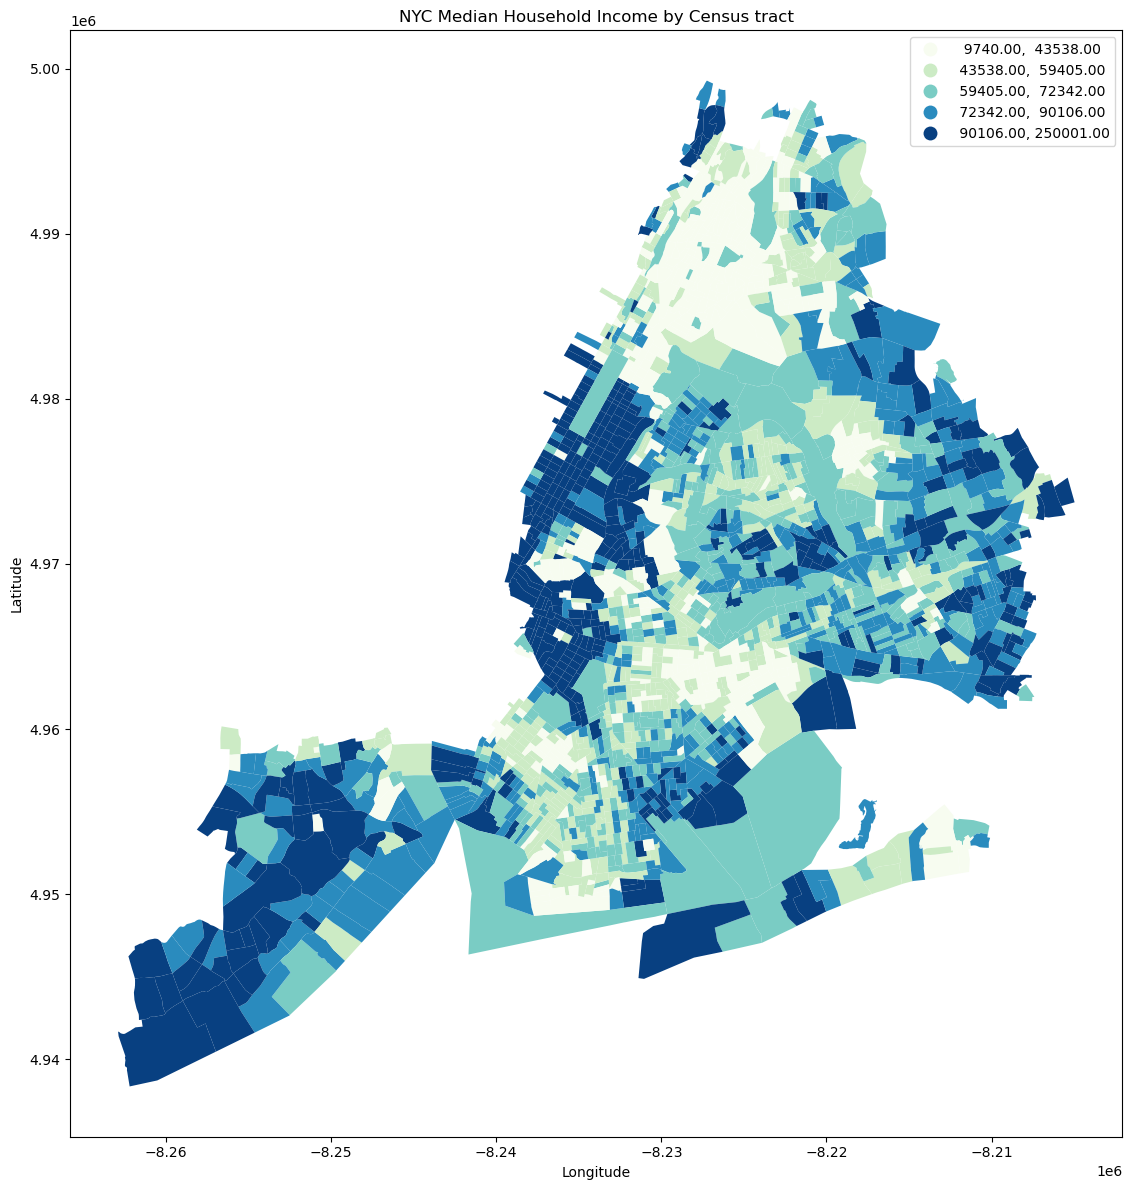

In [9]:
# enter your codes here
fig, ax = plt.subplots(figsize=(12,12))
plt.title("NYC Median Household Income by Census tract")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

acs_data.plot(column='median_hh_inc',
                ax = ax,
                scheme= 'Quantiles',
                k = 5,
                cmap='GnBu',
                legend=True)


## Use tight_layout to remove the white space around the plot
plt.tight_layout()

## 2. Data Analysis & Visualization
### 2.1 Create Spatial Weights (12 pts)
ACS data is firstly analyzed. Create a spatial weight, *wq*, with *Queen* method and standardize the spatial weight. (2 pts)

In [10]:
# enter your codes here
wq = weights.contiguity.Queen.from_dataframe(acs_data)
wq.transform = "R"

('WARNING: ', 229, ' is an island (no neighbors)')


Since *median_hh_inc* column will be used repetitively, store this column in variable *y*. Therefore, *ylag* is generated from *y* to store the spatial lags of *median_hh_inc*. (2 pts)

In [11]:
# enter your codes here
y = acs_data['median_hh_inc']
ylag = weights.spatial_lag.lag_spatial(wq, y)

#add spatial lag to dataframe
acs_data['med_inc_lag'] = ylag

To compare *y* with *ylag* visually, you can create two plots side by side. 
- Both maps should have 5 quantiles of *y* and *ylag* respectively with your choice of color ramp. (2 pts)
- Both maps should have proper titles and legends. (2 pts)
- Remove axis for both maps. (2 pts)

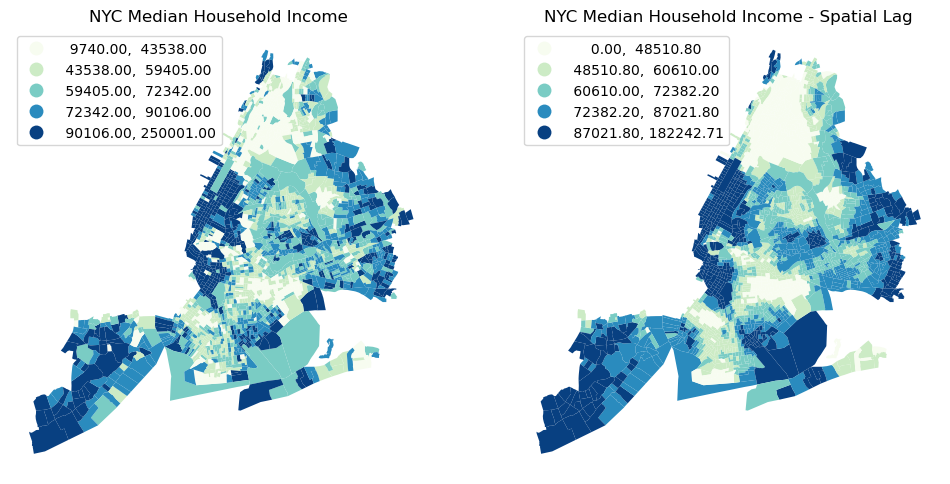

In [12]:
# enter your codes here
f, axs = plt.subplots(1, 2, figsize=(12, 12))
ax1, ax2 = axs
#Plot Median Household Income in first plot
acs_data.plot(column='median_hh_inc',
                ax = ax1,
                scheme= 'Quantiles',
                k = 5,
                cmap='GnBu',
                legend=True,
                legend_kwds={'loc': 'upper left'})
ax1.set_axis_off()
ax1.set_title("NYC Median Household Income ")

#Plot Spatal lag of Median Household Income in second plot
acs_data.plot(column='med_inc_lag',
                ax = ax2,
                scheme= 'Quantiles',
                k = 5,
                cmap='GnBu',
                legend=True,
                legend_kwds={'loc': 'upper left'})
ax2.set_axis_off()
ax2.set_title("NYC Median Household Income - Spatial Lag")


plt.show()

Why do the two maps look different? How do you interpret the difference? (2 pts)

The Map on the left has more distinct census tracts, with no clear spatial pattern in median household income. The map on the right, on the other hand, has a more smoother presentation of the data, with census tracts grouped together into more regional areas. This is due to the properties of the spatial lag, as this statistic essentially represents the local average of median household income in the area around each census tract. From the map on the right, we can see higher trends in median household income in Manhattan and Staten Island, and lower trends in Queens and the Bronx. Overall, differences in median household income among census tracts in the map on the right are smoothed out to make more homogenous regions in the map on the left.  

### 2.2 Global Spatial Correlation (8 pts)
By plotting median household income above, you will have some ideas about where the affluent and the less affluent people live. To verify your hypothesis, you can try to find how they are correlated with their neighbors globally.

Firstly, create a boolean list *yb* if the census tract's median household income (*y*) exceeds the median median household income in Manhattan (median of *y*). (2 pts)

In [13]:
# enter your codes here
yb = y > np.median(y)

Next, create a new column *yb* in **acs_data** where *0 low* means the census tract's median household income is below the median of *y* and *1 high* means the rest. (2 pts)

In [14]:
# enter your codes here
acs_data['yb'] = (y > np.median(y)).astype(int)

Plot census tracts whose household income are above the median as black and those below as white. (2 pts)

<AxesSubplot: >

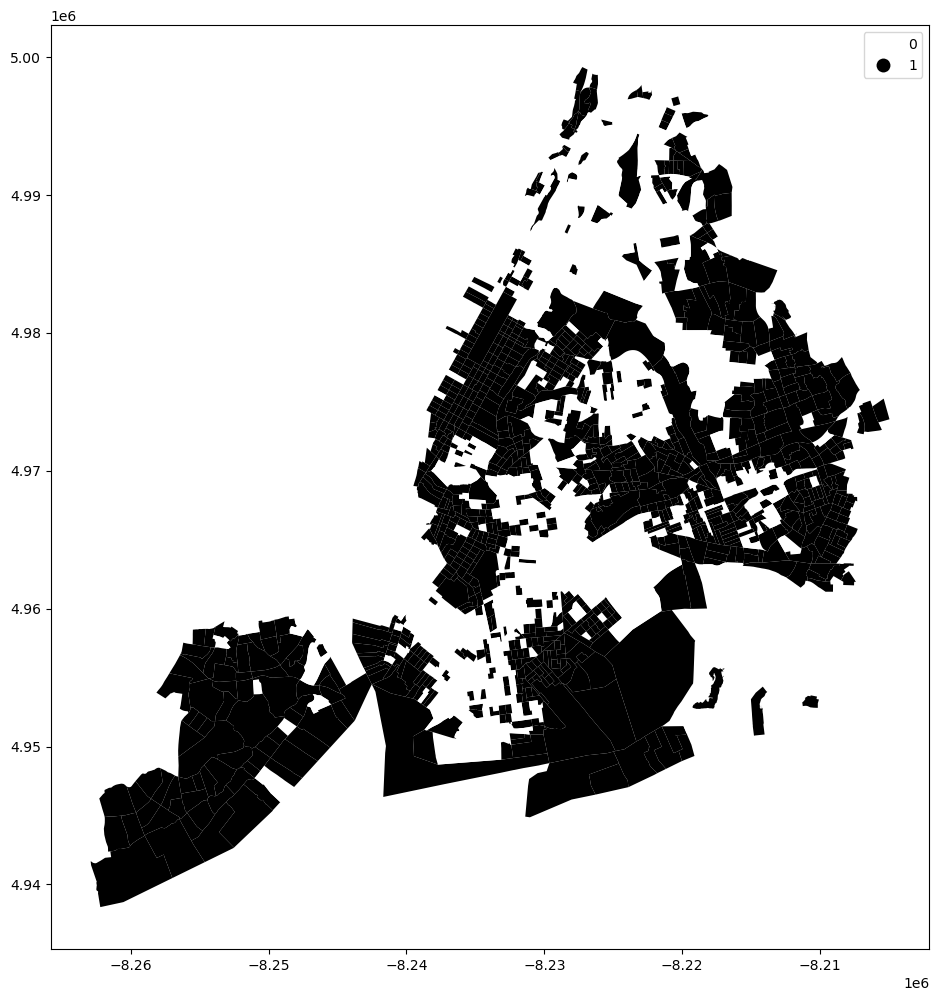

In [15]:
# enter your codes here
fig, ax = plt.subplots(figsize=(12,12))

acs_data.plot(column='yb',
                categorical = True,
                ax = ax,
                cmap='binary',
                legend=True)
                

Do you think a binary map is better at showing spatial disparity than the quantile map in Q2.1? (2 pts)

I don't think this binary map does a better job in showing spatial disparity than the map in 2.1. The binary map does not have enough levels to display the spread in median household income census tract data. This data's distribution presents more of a positive skew towards higher household income values. Therefore, many census tracts have values above the distribution median, making it difficult to discern any noticeable spatial disparities in the data.

### 2.3 Moran's I (8 pts)
By looking at the maps, you are convinced that wealth is not distributed across NYC space evenly. Moran's I will provide you a statistical tool to further testify your hypothesis. 

To create a Moran Plot, you should first calculate the difference between the median household income and its mean. Then repeat the step for the spatial lags of the median household income. Add these two lists to **acs_data** as column *y_std* and *ylag_std*. (2 pts)
Then use seaborn module to make a scatter plot using the two columns. Add x and y axis names and tiles to the plot. (2 pts)

In [16]:
# enter your codes here
acs_data["y_std"] = (y - y.mean())/y.std()
acs_data["ylag_std"] = (
    ylag - ylag.mean()
)/ylag.std()

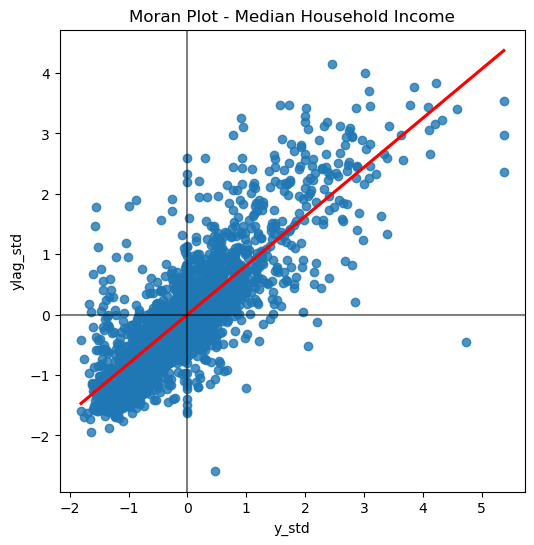

In [17]:
f, ax = plt.subplots(1, figsize=(6, 6))
sns.regplot(
    x="y_std",
    y="ylag_std",
    ci=None,
    data=acs_data,
    line_kws={"color": "r"},
)
ax.axvline(0, c="k", alpha=0.5)
ax.axhline(0, c="k", alpha=0.5)
ax.set_title("Moran Plot - Median Household Income")
plt.show()

How do you interpret the Moran's Plot? Does it indicate a strong or weak autocorrelation? (2 pts)

The Moran's plot presents standardized median household income values at each census tract and their relationship to income values in the surrounding area of each census tract. Dividing the plot into quadrants allows for an interprentation of the spatial orientation of the data. As most of the data points are located in the upper right and lower left quadrants of the plot, this would suggest that high median household income tracts are located in areas where surrounding census tracts also have high median household income values, and low median household income tracts are located in low median household income areas. Overall, this plot indicates a strong positive autocorrelation.  

What is the value of your Moran's I? (2 pts)

In [18]:
# enter your codes here
moran = esda.moran.Moran(y, wq)

moran.I

0.6594848030500569

### 2.4 Local Spatial Autocorrelation (8 pts)
The significant value of Moran's I confirms that the spatial distribution of NYC's wealth is highly uneven. But where are the richest neighborhoods and where are the poorest?

Firstly you can generate local Moran's I and name this variable as *li*. (2 pts)

In [19]:
# enter your codes here
li = esda.moran.Moran_Local(y, wq)

Based on the significance value (less than 0.05), create a new column *cl* to **acs_data** with values of *0 ns*, *1 hot pot*, *2 doughnut*, *3 cold spot*, and *4 diamond*. (2 pts)
As the names indicate, Hot Spot is the neighborhoods with high household income and Cold Spot is the neighborhoods with low household income. Doughnut is the low-income neighborhoods surrounded by high-income neighbors while Diamond is the high-income neighborhoods surrounded by low-income neighbors.

In [20]:
# establish significance of local spatial values
sig = sig = 1 * (li.p_sim < 0.05)
cl = sig * li.q

In [21]:

# Mapping from value to name (as a dict)
cl_labels = {
    0: "0 ns",
    1: "1 hot spot",
    2: "2 doughnut",
    3: "3 cold spot",
    4: "4 diamond",
}
# Create column in `acs_data` with labels for each polygon
acs_data["cl"] = pd.Series(
    # First initialise a Series using values and `acs_data` index
    cl,
    index=acs_data.index
    # Then map each value to corresponding label based
    # on the `cl_labels` mapping
).map(cl_labels)

# Print top for inspection
acs_data["cl"].head()

0          0 ns
1    1 hot spot
2          0 ns
3          0 ns
4    1 hot spot
Name: cl, dtype: object

Plot the four types of census tracts with lightgrey to *0 ns*, red to *1 hot pot*, lightblue to *2 doughnut*, blue to *3 cold spot*, and pink to *4 diamond*. Add legend and titles to the plot. (2 pts)

In [22]:
acs_data[['geometry', 'cl']]

,geometry,cl
0,"POLYGON ((-8262278.990 4946228.710, -8261996.3...",0 ns
1,"POLYGON ((-8257822.870 4945745.990, -8257700.4...",1 hot spot
2,"POLYGON ((-8256173.450 4957701.750, -8256171.1...",0 ns
3,"POLYGON ((-8256709.900 4959461.880, -8256698.5...",0 ns
4,"POLYGON ((-8254594.160 4948740.120, -8254529.4...",1 hot spot
...,...,...
2061,"POLYGON ((-8210354.790 4963345.130, -8210303.5...",0 ns
2062,"POLYGON ((-8209957.050 4967415.210, -8209906.6...",0 ns
2063,"POLYGON ((-8208826.490 4968457.410, -8208815.6...",0 ns
2064,"POLYGON ((-8208676.320 4964872.740, -8208537.3...",0 ns


<AxesSubplot: title={'center': 'Moran Cluster Map of Median Household Income in NYC'}, xlabel='Longitude', ylabel='Latitude'>

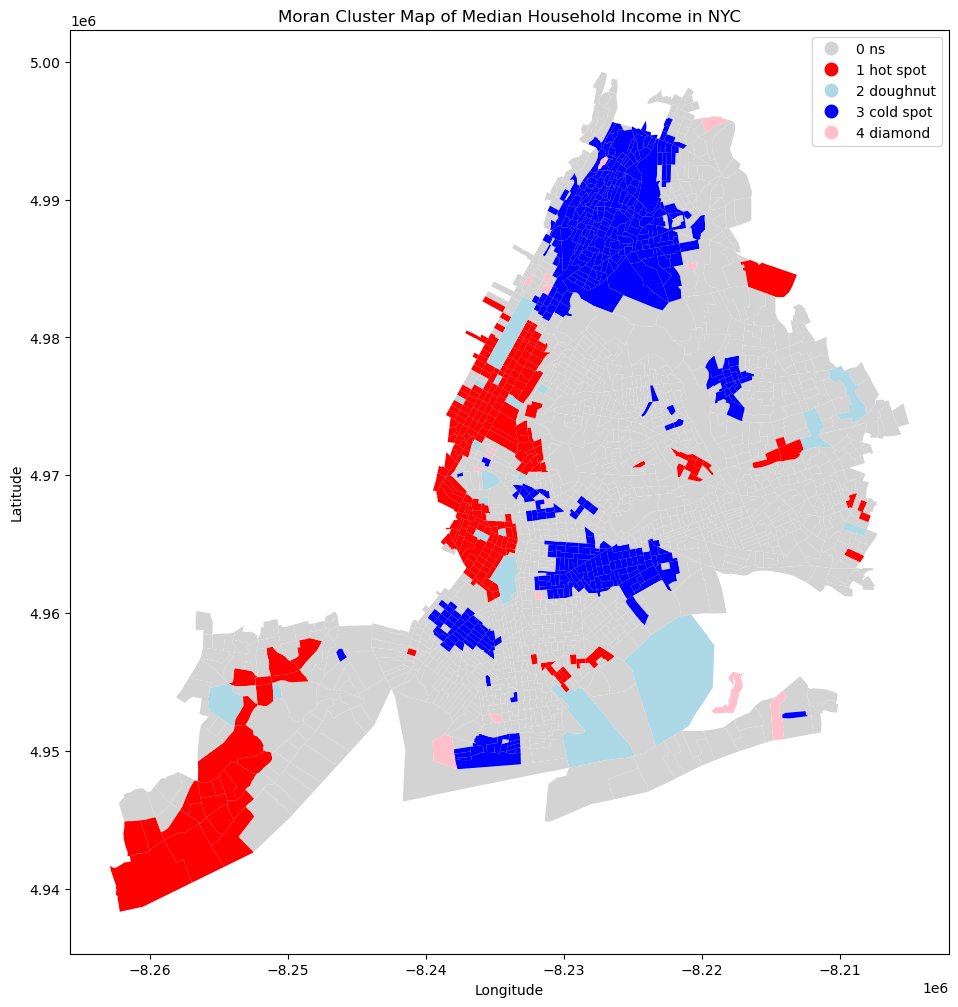

In [23]:

#create color dictionary for creating colormap
tract_col = {"0 ns":'lightgrey', "1 hot spot":'red', "2 doughnut":'lightblue' , "3 cold spot":'blue', "4 diamond":'pink'}

#Create figure
fig, ax = plt.subplots(figsize=(12,12))
plt.title("Moran Cluster Map of Median Household Income in NYC")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

acs_data.plot(column='cl',
                categorical = True,
                ax = ax,
                cmap = colors.ListedColormap(list(tract_col.values())),
                legend = True
                )


How do you interpret the four types of colored regions under the NYC context? Why do some parks apprear as "doughnuts"? (2 pts)

The four types of colored regions represent magnitude of median household income values in each census tract and its relationship with the surrounding area. Hotspot (red) areas are census tracts with high median income values in areas of high median income, while coldspot (blue) areas are low median income census tracts in areas of low median income. Doughnut (light blue) and diamond (pink) areas represent tracts that differ with its surrounding area. Doughnuts are low median income values in high median income neighborhoods, and diamonds are high median income values in low median income neighborhoods. No houses are present within parks, so tracts that include parks would have negligible median household income values with surrounding tracts inevitably having higher income values, creating doughnuts. This relationship is even more pronounced when it is desirable to live around certain parks, such as Central Park in Manhattan.   

### 2.5 Point Pattern Analysis (18 pts)
With an image of wealth distribution across NYC, now you can move to the Airbnb listing to see if locations of the short-term rental listing have any relationship with their neighborhoods.

Map all the listing in Manhattan by their coordinates and show the density on latitudes and longitudes respectively. (2 pts)

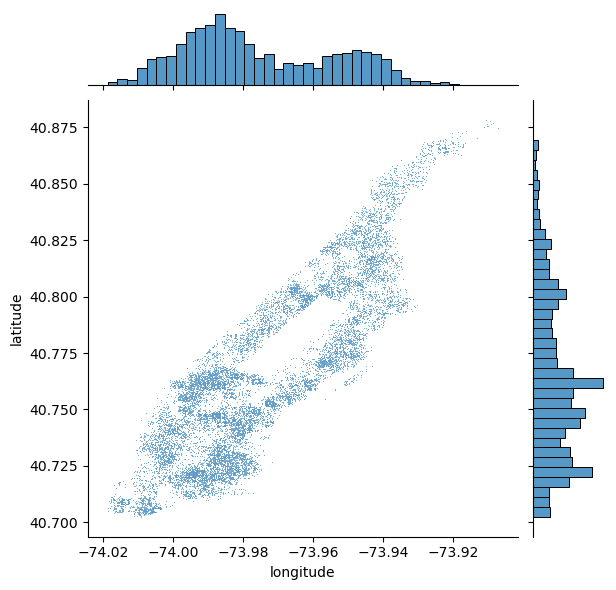

In [24]:
# enter your codes here
sns.jointplot(x="longitude", y="latitude", data=listing, s=0.5)

To generate a density map for points data, you should firstly assign those points to different areal units. Hexagon is one of the most used units. For Manhattan, you can generate and add hexbin with 50 hexagons in each dimension without bordorline and with half transparency. (2 pts) Add a base map and colorbar and remove axes. (2 pts) Show your map below.

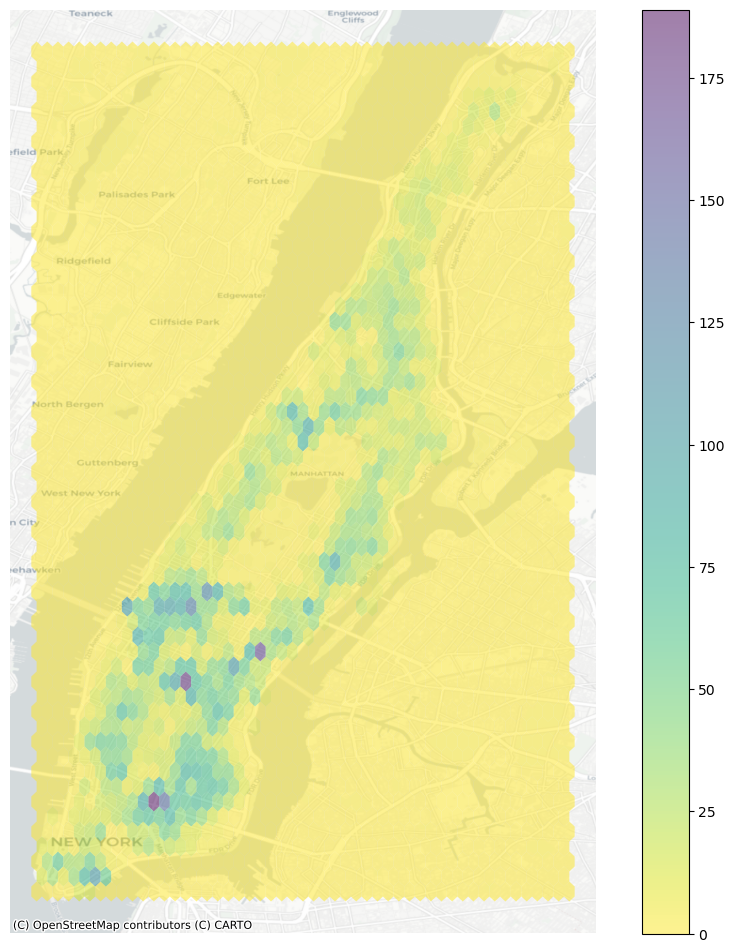

In [25]:
# enter your codes here
# Set up figure and axis
f, ax = plt.subplots(1, figsize=(12, 12))
# Generate and add hexbin with 50 hexagons in each
# dimension, no borderlines, half transparency,
# and the reverse viridis colormap
hb = ax.hexbin(
    listing["longitude"],
    listing["latitude"],
    gridsize=50,
    linewidths=0,
    alpha=0.5,
    cmap="viridis_r",
)
# Add basemap
ctx.add_basemap(
    ax, crs = listing.crs, source=ctx.providers.CartoDB.Positron
)
# Add colorbar
plt.colorbar(hb)
# Remove axes
ax.set_axis_off()

Find out the mean center (2 pts), median center (2 pts) and standardized ellipse of the Manhattan Airbnb listing. Legend and axis names should be added.

In [26]:
# enter your codes here
mean_center = centrography.mean_center(listing[["longitude", "latitude"]].dropna())
med_center = centrography.euclidean_median(listing[["longitude", "latitude"]].dropna())

major, minor, rotation = centrography.ellipse(listing[["longitude", "latitude"]].dropna())

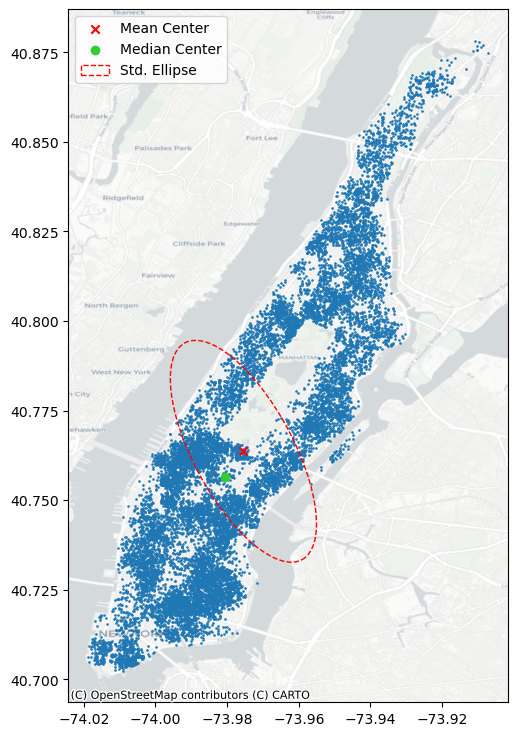

In [27]:
# Set up figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot photograph points
ax.scatter(listing["longitude"], listing["latitude"], s=0.75)
ax.scatter(*mean_center, color="red", marker="x", label="Mean Center")
ax.scatter(
    *med_center, color="limegreen", marker="o", label="Median Center"
)

# Construct the standard ellipse using matplotlib

ellipse = Ellipse(
    xy=mean_center,  # center the ellipse on our mean center
    width=major * 2,  # centrography.ellipse only gives half the axis
    height=minor * 2,
    angle=np.rad2deg(
        rotation
    ),  # Angles for this are in degrees, not radians
    facecolor="none",
    edgecolor="red",
    linestyle="--",
    label="Std. Ellipse",
)
ax.add_patch(ellipse)

ax.legend()
# Display
# Add basemap
ctx.add_basemap(
    ax, crs = listing.crs, source=ctx.providers.CartoDB.Positron
)
plt.show()

Why do the mean and median centers differ? (2 pts)

The median marks the distributional center of the data, or the center of the spatial distribution of listings. Half of the data is located above this point, and half is located below. The mean marks the spatial center of the data, essentially marking the center of the spatial extent of listings. The mean center is higher and more right than the median center because there are more listings located in the upper-right side of the map, pulling the mean in this direction. This center is more sensitive to listings further away from the ellipse than the median. 

Generate a quadrat count map based on the listing. In each quadrat, the number of listings should be shown. (2 pts)

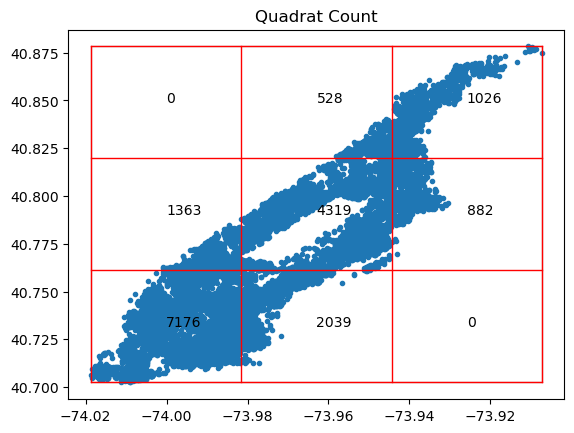

In [28]:
# enter your codes here
qstat_listings = QStatistic(listing[["longitude", "latitude"]].dropna().values)
qstat_listings.plot()

From the Quadrat Count figure, which areas have the densest Airbnbs? Provide some hypotheses for why this might be the case. (2 pts)

The areas with the densest amount of airbnb listings are located in the bottom left four-square of the figure, comprised of the lower left, middle left, center, and lower middle quadrat. This is probably cause most listings are located in lower Manhattan, which these selected quadrats comprise. However, the listings are within and outline Manhattan, and since the grid is larger than the data's spatial extent, the orientation of the mapped out borough will influence wich quadrats are densest. It is impossible for the data to be mapped evenly across all quadrats as this would require listings to exist outside Manhattan, which we have selected against. The spatial pattern present in this plot is Manhattan.  

What is the p-value of a chi-squared test? How do you interpret the value? (2 pts)

In [29]:
# enter your codes here
qstat_listings.chi2_pvalue

0.0

The p-value of this chi-squared test is given as 0.0. This means that the chi-squared test is statistically significant, implying that this spatial distribution is highly unlikely to have been derived from a uniform, random spatial distribution of points. 